In [1]:
# https://gist.github.com/mbednarski/da08eb297304f7a66a3840e857e060a0
import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F

In [2]:
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',   
]

In [3]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)

In [4]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [5]:

window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # Each word is treated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

In [6]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

In [60]:
embedding_dims = 10
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 10001
learning_rate = 0.005

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

Loss at epo 0: 4.560413843286889
Loss at epo 10: 3.0848378811563766
Loss at epo 20: 2.599449124506542
Loss at epo 30: 2.3085314639977046
Loss at epo 40: 2.109593943612916
Loss at epo 50: 1.9755860550062998
Loss at epo 60: 1.889017802476883
Loss at epo 70: 1.8316652353320804
Loss at epo 80: 1.7910164777721678
Loss at epo 90: 1.7600862792560032
Loss at epo 100: 1.7352186982120787
Loss at epo 110: 1.7144906942333493
Loss at epo 120: 1.6968031372342791
Loss at epo 130: 1.6814635183129991
Loss at epo 140: 1.6680187370095934
Loss at epo 150: 1.6561724943774088
Loss at epo 160: 1.6457273772784642
Loss at epo 170: 1.6365384110382626
Loss at epo 180: 1.6284824899264745
Loss at epo 190: 1.6214430110795157
Loss at epo 200: 1.6153054918561662
Loss at epo 210: 1.6099588658128465
Loss at epo 220: 1.6052989082677023
Loss at epo 230: 1.6012309380940029
Loss at epo 240: 1.5976711119924272
Loss at epo 250: 1.5945468928132738
Loss at epo 260: 1.5917960064751762
Loss at epo 270: 1.5893658297402518
Loss at

Loss at epo 2260: 1.5597530705588205
Loss at epo 2270: 1.5597342320850918
Loss at epo 2280: 1.5597154830183302
Loss at epo 2290: 1.5596967535359518
Loss at epo 2300: 1.5596780725887844
Loss at epo 2310: 1.5596595559801374
Loss at epo 2320: 1.5596409491130283
Loss at epo 2330: 1.5596224921090263
Loss at epo 2340: 1.5596040793827601
Loss at epo 2350: 1.5595856964588166
Loss at epo 2360: 1.5595674897943224
Loss at epo 2370: 1.5595491886138917
Loss at epo 2380: 1.5595310543264662
Loss at epo 2390: 1.5595129013061524
Loss at epo 2400: 1.5594948623861586
Loss at epo 2410: 1.5594768030302866
Loss at epo 2420: 1.5594588994979859
Loss at epo 2430: 1.5594410036291395
Loss at epo 2440: 1.5594231860978263
Loss at epo 2450: 1.5594053643090384
Loss at epo 2460: 1.559387709413256
Loss at epo 2470: 1.559369913169316
Loss at epo 2480: 1.55935241154262
Loss at epo 2490: 1.5593347787857055
Loss at epo 2500: 1.5593172754560198
Loss at epo 2510: 1.5592998376914433
Loss at epo 2520: 1.5592823394707271
Loss 

Loss at epo 4500: 1.5566247139658247
Loss at epo 4510: 1.556614318915776
Loss at epo 4520: 1.5566039136477878
Loss at epo 4530: 1.556593656539917
Loss at epo 4540: 1.556583331312452
Loss at epo 4550: 1.5565730648381368
Loss at epo 4560: 1.5565627779279436
Loss at epo 4570: 1.5565525250775474
Loss at epo 4580: 1.5565422901085444
Loss at epo 4590: 1.556532154764448
Loss at epo 4600: 1.556521999835968
Loss at epo 4610: 1.556511904512133
Loss at epo 4620: 1.5565017827919552
Loss at epo 4630: 1.556491732597351
Loss at epo 4640: 1.5564816789967673
Loss at epo 4650: 1.5564716288021632
Loss at epo 4660: 1.5564616518361227
Loss at epo 4670: 1.5564516859395163
Loss at epo 4680: 1.5564417166369302
Loss at epo 4690: 1.5564318111964635
Loss at epo 4700: 1.5564219176769256
Loss at epo 4710: 1.556412033523832
Loss at epo 4720: 1.556402142558779
Loss at epo 4730: 1.5563922601086753
Loss at epo 4740: 1.5563824977193559
Loss at epo 4750: 1.556372675725392
Loss at epo 4760: 1.5563629014151437
Loss at epo

Loss at epo 6740: 1.554768019914627
Loss at epo 6750: 1.554761461700712
Loss at epo 6760: 1.5547547961984363
Loss at epo 6770: 1.5547481732709068
Loss at epo 6780: 1.5547415903636388
Loss at epo 6790: 1.5547350508826119
Loss at epo 6800: 1.5547283513205392
Loss at epo 6810: 1.5547218458993095
Loss at epo 6820: 1.554715337923595
Loss at epo 6830: 1.554708823135921
Loss at epo 6840: 1.5547023040907724
Loss at epo 6850: 1.554695759500776
Loss at epo 6860: 1.554689289842333
Loss at epo 6870: 1.5546828252928597
Loss at epo 6880: 1.5546763147626603
Loss at epo 6890: 1.5546698553221567
Loss at epo 6900: 1.554663391624178
Loss at epo 6910: 1.5546569432531083
Loss at epo 6920: 1.554650557892663
Loss at epo 6930: 1.554644113779068
Loss at epo 6940: 1.5546376943588256
Loss at epo 6950: 1.5546312834535325
Loss at epo 6960: 1.5546249176774707
Loss at epo 6970: 1.554618557010378
Loss at epo 6980: 1.554612217630659
Loss at epo 6990: 1.554605908053262
Loss at epo 7000: 1.5545995099203926
Loss at epo 7

Loss at epo 8980: 1.55353131209101
Loss at epo 8990: 1.5535267182758876
Loss at epo 9000: 1.553522060598646
Loss at epo 9010: 1.5535175025463104
Loss at epo 9020: 1.5535129691873277
Loss at epo 9030: 1.5535083677087511
Loss at epo 9040: 1.5535038598946163
Loss at epo 9050: 1.5534993060997555
Loss at epo 9060: 1.5534947080271584
Loss at epo 9070: 1.5534902019160135
Loss at epo 9080: 1.553485688141414
Loss at epo 9090: 1.5534811283860888
Loss at epo 9100: 1.55347666484969
Loss at epo 9110: 1.5534721553325652
Loss at epo 9120: 1.5534676713602884
Loss at epo 9130: 1.5534631771700722
Loss at epo 9140: 1.5534586829798562
Loss at epo 9150: 1.5534541938986097
Loss at epo 9160: 1.5534496920449392
Loss at epo 9170: 1.553445291519165
Loss at epo 9180: 1.5534407462392534
Loss at epo 9190: 1.5534363652978624
Loss at epo 9200: 1.5534319077219283
Loss at epo 9210: 1.5534274126802172
Loss at epo 9220: 1.553423010451453
Loss at epo 9230: 1.5534185656479427
Loss at epo 9240: 1.553414122547422
Loss at ep

In [50]:
def similarity(v,u):
  return torch.dot(v, v) + torch.dot(u, u) - 2*torch.dot(v,u) #/(torch.norm(v)*torch.norm(u))

print(similarity(W1[:, word2idx["she"]], W1[:, word2idx["king"]]))

print(similarity(W1[:, word2idx["she"]], W1[:, word2idx["queen"]]))
print(similarity(W1[:, word2idx["he"]], W1[:, word2idx["king"]]))

tensor(27.6399, grad_fn=<SubBackward0>)
tensor(15.3072, grad_fn=<SubBackward0>)
tensor(35.0906, grad_fn=<SubBackward0>)


## Visualization

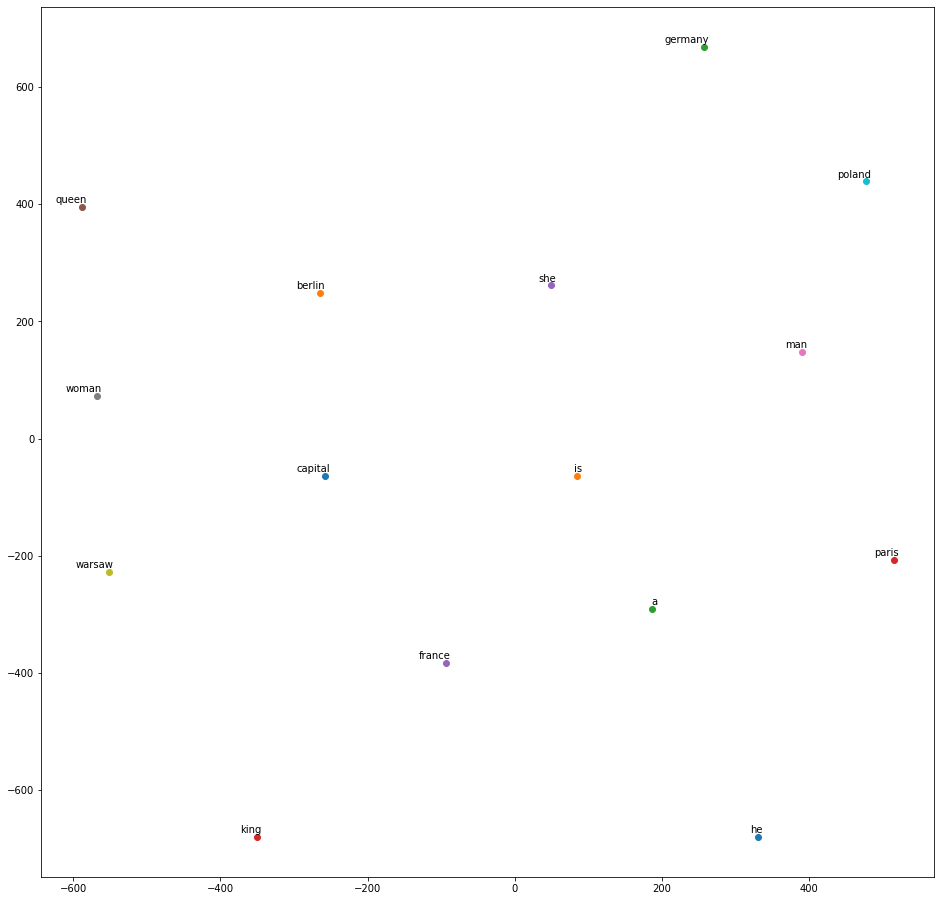

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
tokens = W1.detach().numpy().T
# tokens = W2.detach().numpy()
labels = [val for _, val in idx2word.items()]
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=5000, random_state=40)
new_values = tsne_model.fit_transform(tokens)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
    xy=(x[i], y[i]),
    xytext=(5, 2),
    textcoords='offset points',
    ha='right',
    va='bottom')
plt.show()

In [35]:
idx2word

{0: 'he',
 1: 'is',
 2: 'a',
 3: 'king',
 4: 'she',
 5: 'queen',
 6: 'man',
 7: 'woman',
 8: 'warsaw',
 9: 'poland',
 10: 'capital',
 11: 'berlin',
 12: 'germany',
 13: 'paris',
 14: 'france'}